 <h1>Top 50 Spotify Analysis</h1>

Here we have chosen <b>Spotify API</b> to analyse the song trends in the countries-
'Ireland', 'Spain', 'UK', 'Argentina', 'USA', 'Brazil', 'Italy', 'South Korea' 

<b>Note</b>: Restart Kernel and Run All the cells if the output isn't clear for any python cell.

TASK 1- Fetching song Details

In [107]:
# Side note
# Helpful shortcuts I found for Jupyter Notebook: 
# https://noteable.io/blog/jupyter-notebook-shortcuts-boost-productivity/#:~:text=In%20Jupyter%20Lab%2C%20you%20can,cell%20below%20the%20current%20cell.

In [108]:
# Import the required libraries
import base64
import json
import requests
import os
import time
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go

<h3>Data Parsing</h3>

Below we define a helper function to parse our JSON files

In [109]:
def parse_json(path):
    try:
        fin = open(path, 'rb')
    except FileNotFoundError:
        print(f"File not found: {path}")
    else:
        # print(f"File found: {path}")
        jdata = json.loads(fin.read())
        fin.close()
        return jdata
    return None

Now, let's create the required global variables and the helper functions.

In [110]:
# Spotify API

# Get the client ID from the newly created spotify developer app
client_id = "65369f31a3844ce9b50b71ab23a8b4e6"
# Get the client secret from the newly created spotify developer app
client_secret = "afd4f23f620144bba8b1015a1faa4bc5"

# Base64 encode the client ID and client secret
client_credentials = f"{client_id}:{client_secret}"
client_credentials_base64 = base64.b64encode(client_credentials.encode()).decode()

# Spotify API endpoint for obtaining an access token
token_url = "https://accounts.spotify.com/api/token"

# Spotify API base URL for GET requests
base_url = "https://api.spotify.com/v1"

# Set the parameters for the token request
token_data = {
    "grant_type": "client_credentials"
}

# Set the headers for the token request
token_headers = {
    "Authorization": f"Basic {client_credentials_base64}"
}

# Country names for analysis
locations_of_interest = ['Ireland', 'Spain', 'UK', 'Argentina', 'USA', 'Brazil', 'Italy', 'South Korea']
# Country's Spotify Playlist ID for top 50 songs
playlist_ids = {
    'Ireland': '37i9dQZEVXbKM896FDX8L1',
    'Spain': '37i9dQZEVXbNFJfN1Vw8d9',
    'UK': '37i9dQZEVXbLnolsZ8PSNw',
    'Argentina': '37i9dQZEVXbMMy2roB9myp',
    'USA': '37i9dQZEVXbLRQDuF5jeBp',
    'Brazil': '37i9dQZEVXbMXbN3EUUhlg',
    'Italy': '37i9dQZEVXbIQnj7RRhdSX',
    'South Korea': '37i9dQZEVXbNxXF4SkHj9F'
}

# Raw Data Directory to store unprocessed data
data_dir = "raw_data"

# Location where the unprocessed JSON files are stored
raw_data_path = "raw_data" 
# Location for storing preprocessed data
preprocessed_data_path = "data"

In [111]:
# Dictionary for storing the json data
world_songs = {}

In [112]:
# Function to create a directory if it doesn't exist
# os.listdir()
def create_dir(directory):
    if not os.path.exists(directory):
        print(f"Directory Created!: {directory}")
        os.mkdir(directory)

In [113]:
# Create the necessary directories
create_dir("raw_data") # Directory for storing gathered data
create_dir("data") # Directory for storing preprocessed data further

In [114]:
def get_data(url, endpoint, api_headers={}):
    fetch_url = url
    if not endpoint.startswith("/"):
        fetch_url += "/"
    fetch_url += endpoint
    print(f"\n\nRequesting data from\n{fetch_url}")
    response = requests.get(fetch_url, headers=api_headers)
    print(f"Response Status: {response.status_code}")
    # print(f"Response URL: {response.links}")
    if response.status_code == 200: # Response OK
        json_data = response.text
        return json.loads(json_data)
    print("Response Not Correct!")
    return None

In [115]:
def save_json_data(path, dictionary):
    print(f"Writing data to {path}")
    fout = open(path, "w")
    json.dump(dictionary, fout, indent=4)
    fout.close()

<h3>Steps to fetch song features</h3>

STEP 1- In order to get any sort of data from Spotify API, the user must have an access token. The token is then appended to the header 'Authorization' to make a GET request.

<b>Spotify API Token Status Codes</b>
- 200: Reponse OK.
- 401: Bad or expired token. This can happen if the user revoked a token or the access token has expired. 
- 403: Bad OAuth request (wrong consumer key, bad nonce, expired timestamp...).
- 429: The app has exceeded its rate limits.

STEP 2- Before fetching the songs' audio features, we need to get the song IDs from the top 50 playlists.
We append an array with all songs' name, songs' ID and songs' artists with each country as a key to the metadata dictionary called world_songs.

STEP 3- After getting the meta data for the songs, we can get each song's audio features and save those in a JSON file for further analysis.

The codeblock below executes the steps as required. Note that Spotify API has a request limit. Hence, we introduce a timeout mechanism to access data after some duration.

In [116]:
# STEP 1- Request an access token
token_response = requests.post(token_url, data=token_data, headers=token_headers)
print(token_response)

# Check for correct response
if token_response.status_code == 200:
    # Parse the JSON response to get the access token
    access_token = token_response.json()["access_token"]
    # print(access_token)
    # Set the headers for the API request with the access token
    api_headers = {
        "Authorization": f"Bearer {access_token}"
    }
    
    # STEP 2- Getting the meta data
    # Get the top tracks for each location of interest
    for location in locations_of_interest:
        # Get the playlist ID
        playlist_id = playlist_ids.get(location)
        if playlist_id:
            # Create an endpoint for accessing data from the playlist ID
            endpoint = f"/playlists/{playlist_id}/tracks"           
            top_tracks = get_data(base_url, endpoint, api_headers)
            # print(top_tracks)
            world_songs[location] = []
            for item in top_tracks["items"]:
                 #print(item["track"]["id"])
                artists = []
                for a in item["track"]["artists"]:
                    artists.append(a["name"])
                # Append the song meta data to a dictionary
                world_songs[location].append({"song_name":item["track"]["name"], "id":item["track"]["id"], "artists":artists})   
    
    # STEP 3- Getting the song data and saving as a JSON file
    # Loop through the metadata of the songs stored        
    for country, meta_data in world_songs.items():
        json_data = {}
        print(f"\nlength: {len(meta_data)}")
        i = 0
        for idx in meta_data:
            # print(idx["song_name"])
            # Create an endpoint to access audio features of the song id
            endpoint = f"/audio-features/{idx['id']}" 
            # Get the Audio features
            json_data = get_data(base_url, endpoint, api_headers)
            # Also store the song name and the artist names
            json_data["song_name"] = idx["song_name"]
            json_data["artists"] = idx["artists"]
            #print(json_data)
            index = str(i).zfill(3)
            
            # Write the data to a json file
            file_name = f"{country}_{index}.json"
            path = "".join([data_dir, "/", file_name])
            save_json_data(path, json_data)
            i += 1
            
        # Add a sleep timer so our request count doesn't reach the spotify limit
        time.sleep(10)
    print("Data Gathered!")
else:
    # We have reached this point, which means we haven't been able to access the token
    print("Failed to obtain an access token.")


<Response [200]>


Requesting data from
https://api.spotify.com/v1/playlists/37i9dQZEVXbKM896FDX8L1/tracks


Response Status: 200


Requesting data from
https://api.spotify.com/v1/playlists/37i9dQZEVXbNFJfN1Vw8d9/tracks
Response Status: 200


Requesting data from
https://api.spotify.com/v1/playlists/37i9dQZEVXbLnolsZ8PSNw/tracks
Response Status: 200


Requesting data from
https://api.spotify.com/v1/playlists/37i9dQZEVXbMMy2roB9myp/tracks
Response Status: 200


Requesting data from
https://api.spotify.com/v1/playlists/37i9dQZEVXbLRQDuF5jeBp/tracks
Response Status: 200


Requesting data from
https://api.spotify.com/v1/playlists/37i9dQZEVXbMXbN3EUUhlg/tracks
Response Status: 200


Requesting data from
https://api.spotify.com/v1/playlists/37i9dQZEVXbIQnj7RRhdSX/tracks
Response Status: 200


Requesting data from
https://api.spotify.com/v1/playlists/37i9dQZEVXbNxXF4SkHj9F/tracks
Response Status: 200

length: 50


Requesting data from
https://api.spotify.com/v1/audio-features/0mflMxspEfB0VbI1kyLiAv
Response Status: 200
Writing data to raw_data/Ireland_000.json


Requesting data from
https://api.spot

TASK 2- Preprocessing and Analysis

Load the saved dataset from Task 1 into an appropriate data structure.

In [117]:
# A dictionary that will store all the JSON data containing song features for each country
json_data = {}
    
for root, dirs, files in os.walk(raw_data_path, topdown=False):
    for name in files:
        file_str = os.path.splitext(name)[0]
        file_str = file_str.split("_")
        country_name = file_str[0]
        song_id = file_str[1]
        if country_name in locations_of_interest:
            if json_data.get(country_name) == None:
                json_data[country_name] = []
            # print(f"{country_name}-{song_id}")
            json_data[country_name].append(parse_json(os.path.join(root, name)))

        
json_data

{'USA': [{'danceability': 0.755,
   'energy': 0.835,
   'key': 5,
   'loudness': -4.68,
   'mode': 0,
   'speechiness': 0.277,
   'acousticness': 0.0635,
   'instrumentalness': 0,
   'liveness': 0.151,
   'valence': 0.575,
   'tempo': 151.953,
   'type': 'audio_features',
   'id': '0fyP96TikhD9sM4eKqw5Yp',
   'uri': 'spotify:track:0fyP96TikhD9sM4eKqw5Yp',
   'track_href': 'https://api.spotify.com/v1/tracks/0fyP96TikhD9sM4eKqw5Yp',
   'analysis_url': 'https://api.spotify.com/v1/audio-analysis/0fyP96TikhD9sM4eKqw5Yp',
   'duration_ms': 265305,
   'time_signature': 4,
   'song_name': 'dangerous',
   'artists': ['21 Savage', 'Lil Durk', 'Metro Boomin']},
  {'danceability': 0.781,
   'energy': 0.567,
   'key': 1,
   'loudness': -7.857,
   'mode': 1,
   'speechiness': 0.0969,
   'acousticness': 0.0504,
   'instrumentalness': 0,
   'liveness': 0.0981,
   'valence': 0.0743,
   'tempo': 121.964,
   'type': 'audio_features',
   'id': '6uTPdRrEDeH8Fyg5L5qmeU',
   'uri': 'spotify:track:6uTPdRrEDeH

<h3>Data Preprocessing</h3>

My analysis includes, checking for any trends with respect to the following features of the song: 

- <b>Energy</b>: Is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

- <b>Danceability</b>: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.


- <b>Loudness</b>: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.

- <b>Speechiness</b>: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

- <b>Song Duration</b>: The duration of the track in milliseconds.

- <b>Artists</b>: Names of all the artists featured in the track.

Reference: https://developer.spotify.com/documentation/web-api/reference/get-audio-features

First step in preprocessing is to load the entire data into a <i>Pandas Data Frame</i> by taking into account the desired features.

In [118]:
# Put the data of interest in the pandas dataframe
df_songs = []
for location in locations_of_interest:
    # print(year)
    for element in json_data[location]:
        e = {"country":location}
        e["energy"] = element["energy"]
        e["danceability"] = element["danceability"]
        e["loudness"] = element["loudness"]
        e["speechiness"] = element["speechiness"]
        e["duration_ms"] = element["duration_ms"]
        e["artists"] = element["artists"]
        df_songs.append(e)
        
df_songs = pd.DataFrame(df_songs)
df_songs

,country,energy,danceability,loudness,speechiness,duration_ms,artists
0,Ireland,0.575,0.821,-6.570,0.0589,159401,[Tate McRae]
1,Ireland,0.658,0.596,-7.346,0.0360,229478,[Taylor Swift]
2,Ireland,0.192,0.369,-12.151,0.0400,228013,[Zach Bryan]
3,Ireland,0.854,0.477,-5.274,0.0896,191591,"[Sonny Fodera, MK, Clementine Douglas]"
4,Ireland,0.453,0.429,-7.746,0.0459,227196,"[Zach Bryan, Kacey Musgraves]"
...,...,...,...,...,...,...,...
395,South Korea,0.755,0.623,-5.386,0.0415,212254,[Jimin]
396,South Korea,0.394,0.401,-6.655,0.0324,274387,[Lim Young Woong]
397,South Korea,0.363,0.314,-7.236,0.0289,238107,[Lim Young Woong]
398,South Korea,0.515,0.279,-4.511,0.0305,233360,[Lim Young Woong]


The next block contains functions for checking for any missing values and applying preprocessing techniques that might be required to clean, filter or transform the dataset before analysis.

In [119]:

# Function to check for missing values in the data frame
def check_missing(df):
    for column in df.columns:
        missing_values = df[column].isna().sum()
        print(f"Column '{column}' has {missing_values} missing values.")  
    
# Function to filter any unknown ascii characters
def filter_data(df):
    for key, value in df.items(): 
        value = remove_unicode_chars(str(value))
        
# Function that removes unknown ascii characters   
def remove_unicode_chars(input_str):
    return input_str.encode('ascii', 'ignore').decode()

# Function to check if a value is of string type
def is_string(value):
    return isinstance(value, str)

# Function to check if a values is of Int or Float type  
def check_num(value):
    return isinstance(value, float) or isinstance(value, int)
 
# Function to check if a value lies in a particular range   
def check_range(value, min_val, max_val):
    if check_num(value):
        if min_val <= value <= max_val:
            return value
    return min_val

We need to find if there is any unknown or incorrect values in a particular column. So we iterate through all the values for our columns.

In [120]:
# Check if any country is not a string
for index, value in df_songs["country"].items():
    if not is_string(value):
        print(f"{value} not valid in country!")

# Check for energy range
min_energy = 0.0
max_energy = 1.0
for index, value in df_songs["energy"].items():
    if not check_range(value, min_energy, max_energy):
        print(f"{value} not valid in energy!")
        
# Check for danceability range        
min_danceability = 0.0
max_danceability = 1.0
for index, value in df_songs["danceability"].items():
    if not check_range(value, min_danceability, max_danceability):
        print(f"{value} not valid in danceability!")   

# Check for the loudness range
min_loudness = -60
max_loudness = 0
for index, value in df_songs["loudness"].items():
    if not check_range(value, min_loudness, max_loudness):
        print(f"{value} not valid in loudness!")
    
# Check for any incorrect value in speechiness column    
for index, value in df_songs["speechiness"].items():
    if not check_num(value):
        print(f"{value} not valid in speechiness!")
   
# Check for any incorrect value in duration_ms column 
for index, value in df_songs["duration_ms"].items():
    if not check_num(value):
        print(f"{value} not valid in duration_ms!")

# Check if a artist name is not valid
for index, value in df_songs["artists"].items():
    #print(value)
    for artist in value:
        # print(artist[0])
        if not is_string(artist):
            print(f"{artist} not valid in artists!")
            break

If none of the print statements were executed, that means our data was clean and no unknown values were found.

In [121]:
# Check for missing values in each column of the data frame
check_missing(df_songs)

Column 'country' has 0 missing values.
Column 'energy' has 0 missing values.
Column 'danceability' has 0 missing values.
Column 'loudness' has 0 missing values.
Column 'speechiness' has 0 missing values.
Column 'duration_ms' has 0 missing values.
Column 'artists' has 0 missing values.


Now our preprocessing is complete. This step makes sure that we have no missing or non uniform values.

We can save the preprocessed data to a json file in the data directory

In [122]:
# Save the preprocessed data to json file
fname = "Song_Data.json"
out_path = f"{preprocessed_data_path}/{fname}"
print(f"Writing {out_path}")
df_songs.to_json(out_path, orient="index", indent=4)

Writing data/Song_Data.json


<h3>Data Verification</h3>

We perform a check on all the columns that we have got after cleaning

In [123]:
df_songs.head(5).set_index("country")

,energy,danceability,loudness,speechiness,duration_ms,artists
country,,,,,,
Ireland,0.575,0.821,-6.570,0.0589,159401,[Tate McRae]
Ireland,0.658,0.596,-7.346,0.0360,229478,[Taylor Swift]
Ireland,0.192,0.369,-12.151,0.0400,228013,[Zach Bryan]
Ireland,0.854,0.477,-5.274,0.0896,191591,"[Sonny Fodera, MK, Clementine Douglas]"
Ireland,0.453,0.429,-7.746,0.0459,227196,"[Zach Bryan, Kacey Musgraves]"


In [124]:
print(f"The data set contains {len(df_songs)} rows")

The data set contains 400 rows


<h3>Data Analysis</h3>

We are going to analyze, characterize, and summarize the cleaned dataset using tables and visualizations where appropriate.

We start the analysis by grouping songs for each country.

In [125]:
# A function to group data by column name
def group_df(df, column_name):
    return df.groupby(column_name)

# Group songs based on country
df_songs_grouped = group_df(df_songs, 'country')

A function to compute Min, Max, Mean, Median, Standard Deviation and Variance can help identify the range of values in the data set.

In [126]:
def compute_stats(df, group_col_name, factor_col_name):
    grouped = group_df(df, group_col_name)[factor_col_name]
    maxi = grouped.max()
    mini = grouped.min()
    mean = grouped.mean()
    std_dev = grouped.std()
    variance = grouped.var()
    median = grouped.median()
    mode = grouped.apply(lambda x: x.mode().values[0] if not x.mode().empty else None)
    
    stats = pd.DataFrame({
        'Max': maxi,
        'Min': mini,
        'Mean': mean,
        'Median': median,
        'Mode': mode,
        'Std Dev': std_dev,
        'Variance': variance,     
    })
    
    return stats

# Energy Analysis

We want to check for what is the highest, lowest, mean, median, mode, standard deviation and variance for the energy values.

In [127]:
# Energy Analysis for songs wrt each country
stats_df = compute_stats(df_songs,'country', 'energy')
stats_df

,Max,Min,Mean,Median,Mode,Std Dev,Variance
country,,,,,,,
Argentina,0.900,0.4210,0.691880,0.7000,0.630,0.115237,0.013280
Brazil,0.960,0.2280,0.739300,0.7550,0.228,0.161505,0.026084
Ireland,0.911,0.0911,0.612722,0.6285,0.758,0.188749,0.035626
Italy,0.886,0.4210,0.710940,0.7530,0.421,0.121201,0.014690
South Korea,0.889,0.2740,0.646280,0.6715,0.830,0.172298,0.029687
Spain,0.907,0.2950,0.699520,0.7150,0.718,0.119754,0.014341
UK,0.976,0.0911,0.626762,0.6330,0.758,0.184188,0.033925
USA,0.905,0.0911,0.641162,0.6640,0.686,0.165158,0.027277


The table above gives some general statistics of the data distribution across each country. Below is the visualisation of the same data.

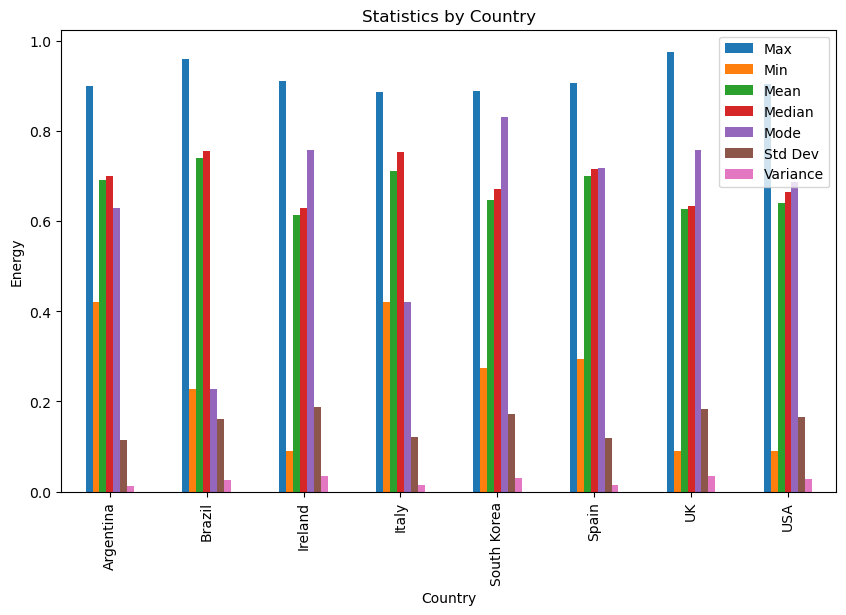

In [128]:
# Plotting the computed stats as bar graphs
stats_df.plot(kind='bar', figsize=(10, 6))
plt.title('Statistics by Country')
plt.ylabel('Energy')
plt.xlabel('Country')
plt.show()

Here, we see a common trend among all the countries, where the highest energy is near to 1. On the other hand the min approximately ranges from 0.5 to 0.1. 

We can plot the energy levels individually for all the countries respectively to verify the computed properties.

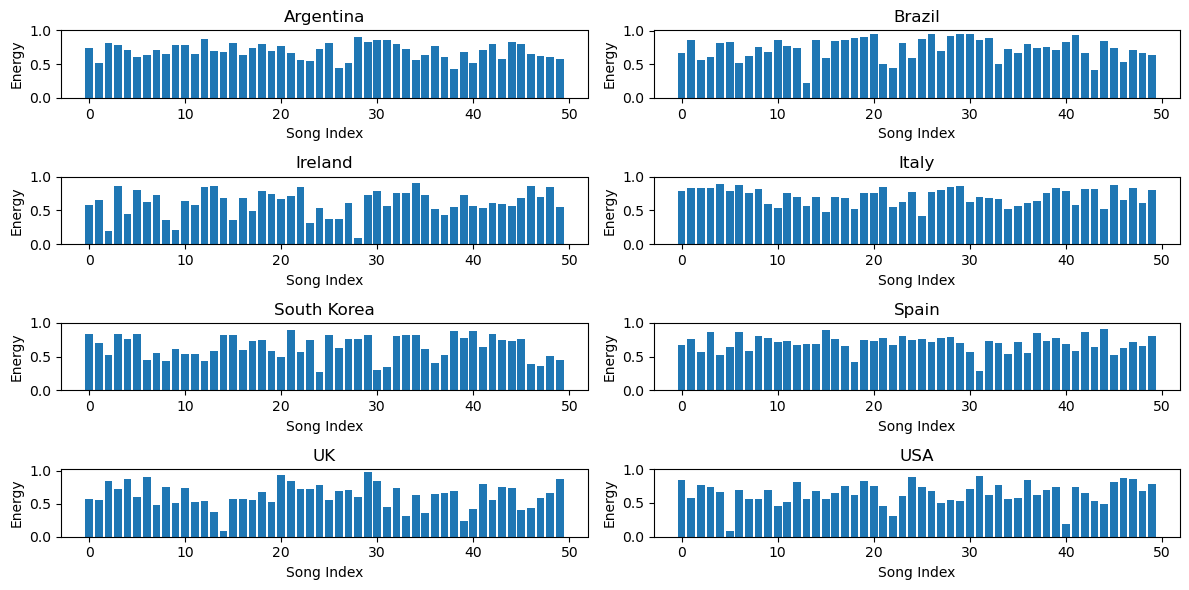

In [129]:
# Create subplots with two plots per row
graphs_per_row = 2
nrows = (len(df_songs_grouped) + 1) // graphs_per_row
fig, axes = plt.subplots(nrows=nrows, ncols=graphs_per_row, figsize=(12, 6))

for (country, group), ax in zip(df_songs_grouped, axes.ravel()):
    ax.bar(range(len(group)), group['energy'])
    ax.set_title(f'{country}')
    ax.set_xlabel('Song Index')
    ax.set_ylabel('Energy')
    y_ticks = np.arange(0, 1.1, 0.5)
    ax.set_yticks(y_ticks)
plt.tight_layout()
plt.show()

For verification purposes, we can individually check for the song index number and it's corresponding energy level. But when all the songs are plotted for each country together, we don't get a clear view of how the songs are distributed across the range 0 to 1. In this case a histogram plot could provide more insight in the values.

So now, for each country group dataframe we can plot a histogram. 

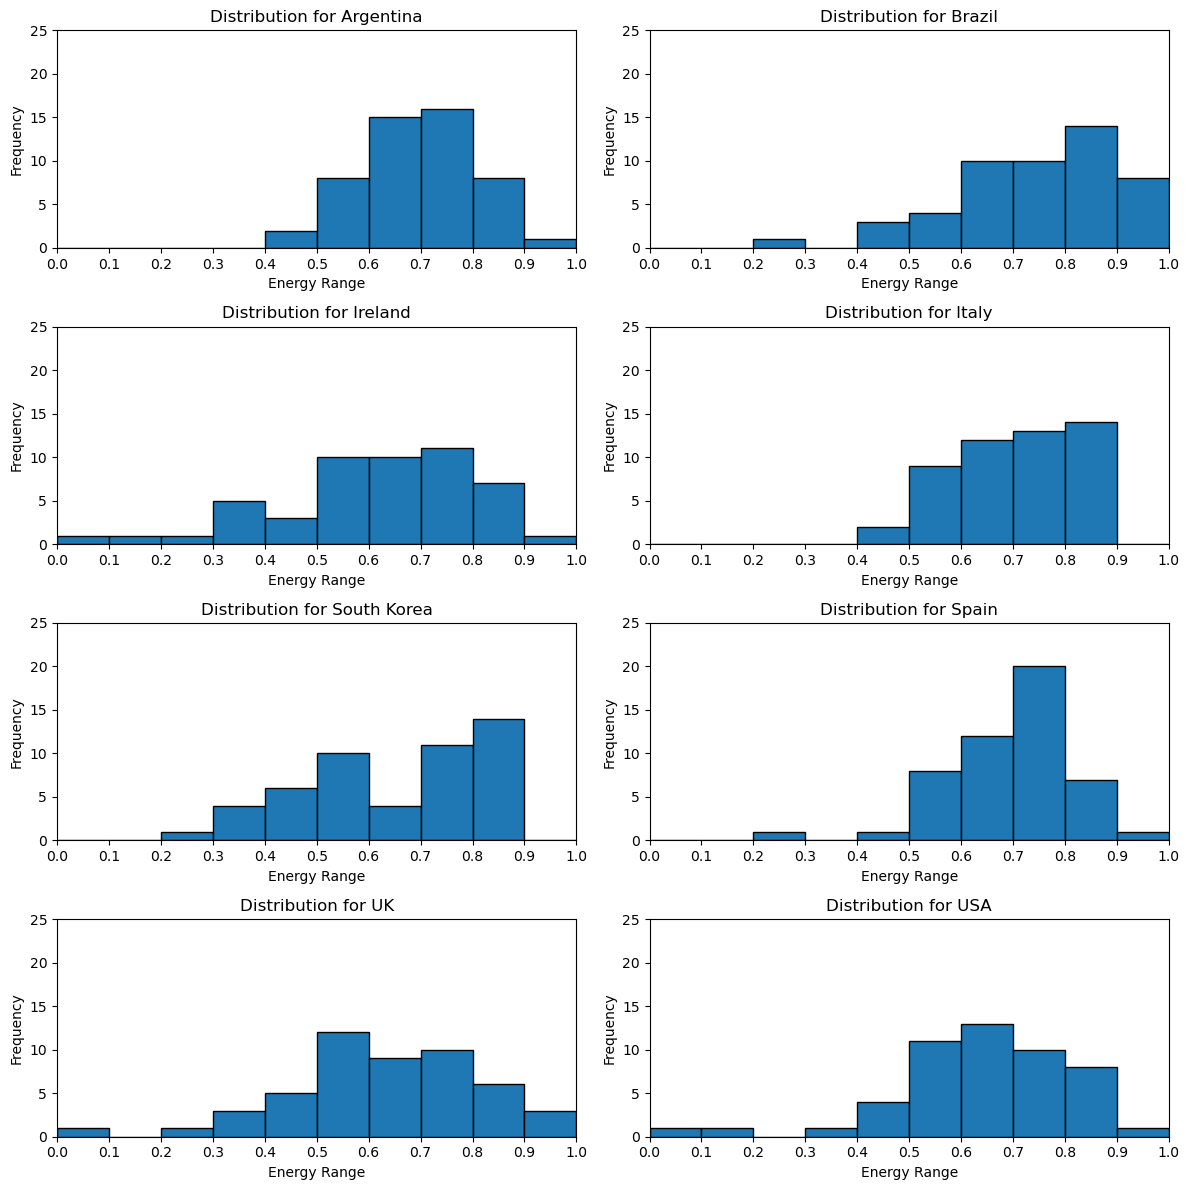

In [130]:
# plot a bhistogram to check the frequency of range of values
graphs_per_row = 2
nrows = (len(df_songs_grouped) + 1) // graphs_per_row
fig, axes = plt.subplots(nrows=nrows, ncols=graphs_per_row, figsize=(12, 12))

# Plot histograms for each grouped country
for (country, group), ax in zip(df_songs_grouped, axes.ravel()):

    ax.hist(group['energy'], bins=[i/10 for i in range(11)], edgecolor='k')
    ax.set_title(f'Distribution for {country}')
    ax.set_xlabel('Energy Range')
    ax.set_ylabel('Frequency')
    ax.set_xticks([i/10 for i in range(11)])  # Set x-axis ticks to match bins
    ax.set_yticks([i*5 for i in range(6)])  # Set y-axis intervals to 5

    ax.set_xlim(0, 1)  # Set x-axis limits to 0 and 1

plt.tight_layout()
plt.show()

Here we can clearly see that,
In Argentina songs with energy factor in 0.6-0.8 are more polpular.
In Brazil songs with energy factor in 0.8-0.9 are more polpular.
In Ireland the energy levels 0.6-0.7 and 0.8-0.9 are popular.
In Italy songs with energy factor in 0.7-0.8 are more polpular.
In South Korea, the range 0.5-0.6 is popular.
In Spain, songs with energy level 0.7-0.8 are more popular.
In UK, the range is normally distributed across 0.3 to 1.0 where 0.5-0.6 and 0.8-0.9 are the popular ranges.
In USA, songs with the energy range 0.6-0.7 are more trending.


Thus, we can conclude that most countries (among listed) have songs trending in the energy range 0.6-0.8

Let's use box plots to examine the distribution of values for each country.

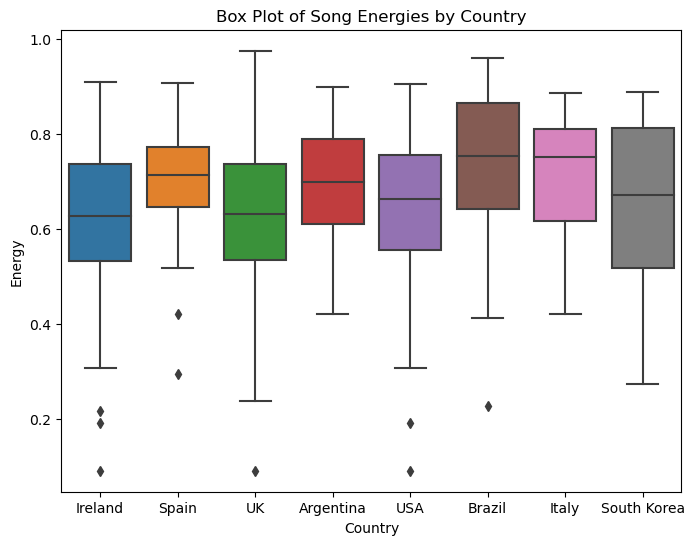

In [131]:
# Create box plots for each group
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_songs, x='country', y='energy')
plt.title('Box Plot of Song Energies by Country')
plt.xlabel('Country')
plt.ylabel('Energy')
plt.show()

These box plots show the median, the range distribution as well as outliers in the data. The box plots can verify our findings that energy ranges of 0.6-0.8 are trending in most countries.

We also see that there are some outliers or energy values which are significantly different than the common ranges. Such outliers are present of the countries- Ireland, Spain, UK, USA and Brazil.

# Danceability Analysis

Now we can take the next variable into consideration, which danceability. We can find trending danceability factors for each country.

We can check the general statistics from the function created before.

In [132]:
# Danceability Analysis for songs wrt each country
stats_df = compute_stats(df_songs,'country', 'danceability')
stats_df

,Max,Min,Mean,Median,Mode,Std Dev,Variance
country,,,,,,,
Argentina,0.911,0.479,0.72846,0.7330,0.730,0.098070,0.009618
Brazil,0.947,0.350,0.66926,0.6805,0.664,0.143761,0.020667
Ireland,0.943,0.352,0.61942,0.6180,0.486,0.143705,0.020651
Italy,0.949,0.452,0.70892,0.7320,0.452,0.105649,0.011162
South Korea,0.900,0.279,0.62766,0.6425,0.633,0.153991,0.023713
Spain,0.911,0.470,0.73854,0.7600,0.668,0.096311,0.009276
UK,0.943,0.352,0.63196,0.6330,0.504,0.141844,0.020120
USA,0.943,0.369,0.67012,0.6625,0.559,0.138739,0.019248


Plotting these stats as bar graphs can help with better visualisation.

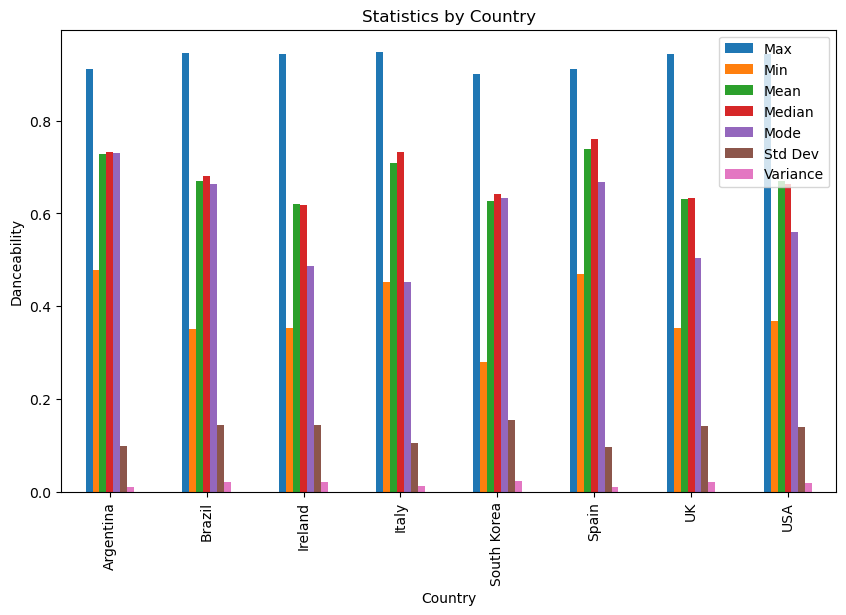

In [133]:
stats_df.plot(kind='bar', figsize=(10, 6))
plt.title('Statistics by Country')
plt.ylabel('Danceability')
plt.xlabel('Country')
plt.show()

Here we too have quite a common max trend for each country. However, the min values have a variety.

Let us check the danceabilites of each song individually for each country as scatter plots.

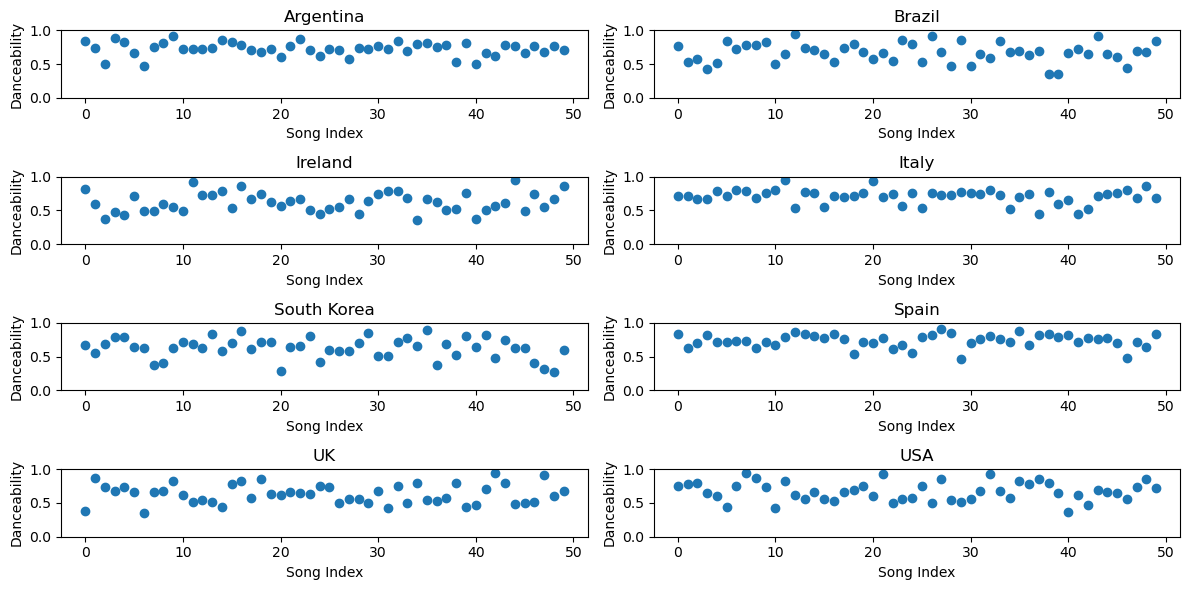

In [134]:
# Create subplots with two plots per row
graphs_per_row = 2
nrows = (len(df_songs_grouped) + 1) // graphs_per_row
fig, axes = plt.subplots(nrows=nrows, ncols=graphs_per_row, figsize=(12, 6))

for (country, group), ax in zip(df_songs_grouped, axes.ravel()):
    ax.scatter(range(50), group['danceability'])
    ax.set_title(f'{country}')
    ax.set_xlabel('Song Index')
    ax.set_ylabel('Danceability')
    y_ticks = np.arange(0, 1.1, 0.5)
    ax.set_yticks(y_ticks)
plt.tight_layout()
plt.show()

Looking at the scatter plots we can see the danceability factors for trending songs in Argentina, Italy and Spain have high values compared to other countries. 

We can plot histograms for further in-depth analysis.

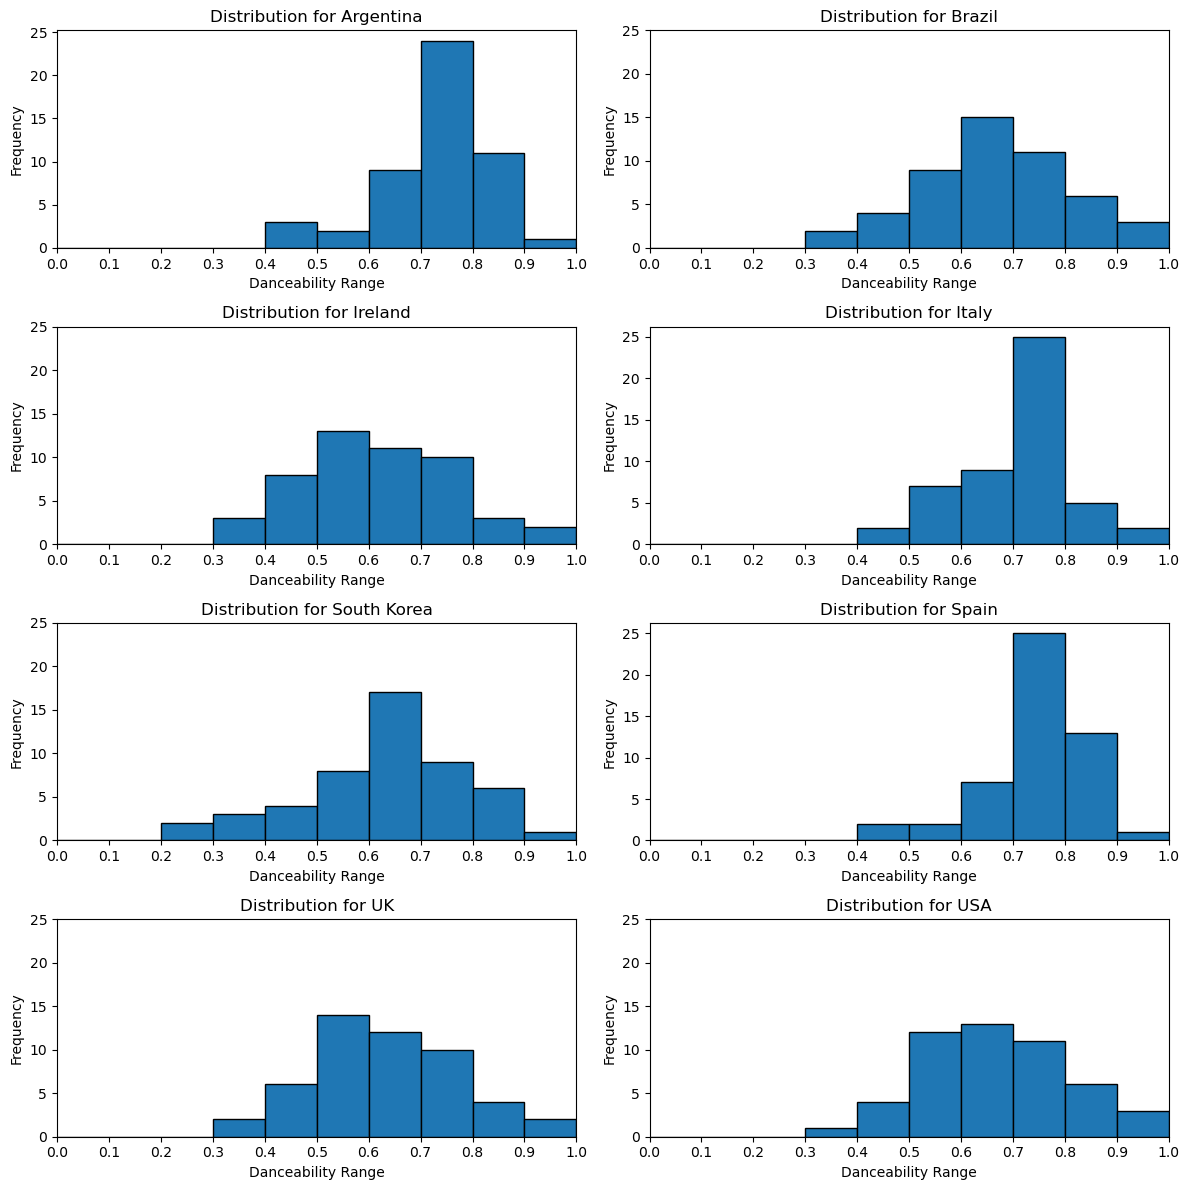

In [135]:
graphs_per_row = 2
nrows = (len(df_songs_grouped) + 1) // graphs_per_row
fig, axes = plt.subplots(nrows=nrows, ncols=graphs_per_row, figsize=(12, 12))

# Plot histograms for each grouped country
for (country, group), ax in zip(df_songs_grouped, axes.ravel()):

    ax.hist(group['danceability'], bins=[i/10 for i in range(11)], edgecolor='k')
    ax.set_title(f'Distribution for {country}')
    ax.set_xlabel('Danceability Range')
    ax.set_ylabel('Frequency')
    ax.set_xticks([i/10 for i in range(11)])  # Set x-axis ticks to match bins
    ax.set_yticks([i*5 for i in range(6)])  # Set y-axis intervals to 5

    ax.set_xlim(0, 1)  # Set x-axis limits to 0 and 1

plt.tight_layout()
plt.show()

These histograms show that for Argentina, Italy and Spain, songs with higher danceability values are more popular.

We also see two groups of ranges i) 0.6-0.7 and ii) 0.7-0.8 which are popular.

- Countries with higher popularity for range 0.6-0.7 are: Brazil, Ireland, South Korea, UK, USA.

- Countries with higher popularity for range 0.7-0.8 are: Argentina, Italy, Spain.

Displaying the danceability ranges as Box plot for each country:

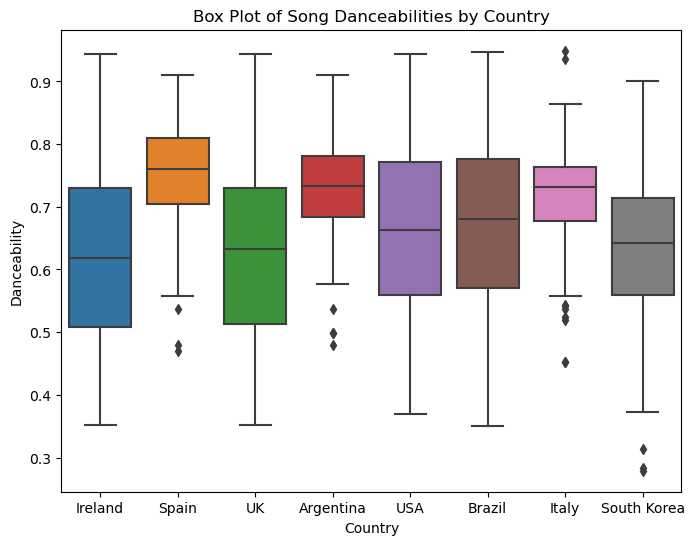

In [136]:
# Create box plots for each group
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_songs, x='country', y='danceability')
plt.title('Box Plot of Song Danceabilities by Country')
plt.xlabel('Country')
plt.ylabel('Danceability')
plt.show()

In the box plot above, the visualisation tells us the danceability ranges in all countries at the same time. In all the cases the median lies in the range 0.6 to 0.8. 

We do see some outliers in the ranges for the countries Argentina, Brazil, Spain and South Korea.

My assumption is that the factors 'energy' and 'danceability' have some kind of correlation. Usually when a song is danceable it has a high energy and vice versa. Let's check if there is any correlation between the attributes.

First we can calculate the covariance  matrix from the grouped songs and display a table of the matrix.

In [137]:
# Calculate the correlation matrix for the values
grouped_cr = df_songs_grouped[['energy', 'danceability']].corr()

# Reshape the correlation matrix for heatmap
correlation_matrix = grouped_cr.unstack(level=0).droplevel(0, axis=1)
correlation_matrix.T

,energy,danceability
country,,
Argentina,1.000000,0.176738
Brazil,1.000000,-0.105349
Ireland,1.000000,0.347519
Italy,1.000000,0.234037
South Korea,1.000000,0.476168
Spain,1.000000,0.270474
UK,1.000000,0.260702
USA,1.000000,0.246748
Argentina,0.176738,1.000000


Plotting a heatmap to help better visualise.

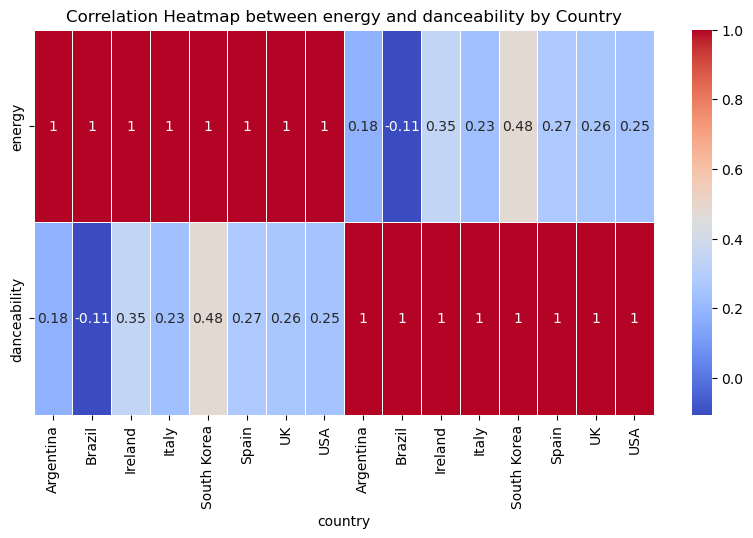

In [138]:
# Plot the matrix as a heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap between energy and danceability by Country')
plt.show()

In the above heatmap, the Y axis represents the two columns and X axis represents the country. One way to read the map would be to check for a country correspondingly then check how the attributes are related to each other. This means that, we can see that the heatmap is divded into 4 sections. 
- The section on the <b>Top Left</b> compares 'energy' & 'energy'. 
- The section on <b>Top Right</b> compares 'energy' & 'danceability'. 
- The section on <b>Bottom Left</b> compares 'danceability' & 'energy'.
- The section on <b>Bottom Right</b> compares 'danceability' & 'danceablity'.

One thing to note would be the attribute comparisons are associative. Thus comparing 'danceability' & 'energy' or 'energy' & 'danceability' would have same value in the heatmap.

We can observe based on the values of correlation matrix that my assumption stated before holds somewhat (26 percent) true only for songs in USA. We can clearly say that there is no direct relation between the 'energy' and the 'danceability' factor of a song.

# Loudness Analysis

Attributes studied so far were in the range 0 to 1. We are going to study an attribute which lies on a logarithmic scale.


According to Wikipedia- "Loudness is the subjective perception of sound pressure."

Let us first sort the loudness in descending order before looking at individual songs.

In [139]:
# Sort all the songs based on their loudness
df_sorted = df_songs.sort_values(by='loudness',ascending=False)
# Group them by their country
df_grouped = df_sorted.groupby('country')
# Loudest songs within countries
df_sorted.head(5).set_index('country')

,energy,danceability,loudness,speechiness,duration_ms,artists
country,,,,,,
UK,0.935,0.620,-0.504,0.2520,177292,"[Chase & Status, Bou, Flowdan, IRAH, Trigga, T..."
UK,0.976,0.504,-0.653,0.0946,164571,"[Becky Hill, Chase & Status]"
Brazil,0.750,0.947,-0.855,0.0534,163200,[Felipe Amorim]
Brazil,0.960,0.863,-1.458,0.0492,92093,"[DENNIS, MC Kevin o Chris]"
South Korea,0.872,0.644,-1.540,0.0417,214973,[aespa]


Table above shows that UK dominates other countries with top 3 songs being the loudest. We can plot the sorted loudness for each country and display the graph for all.

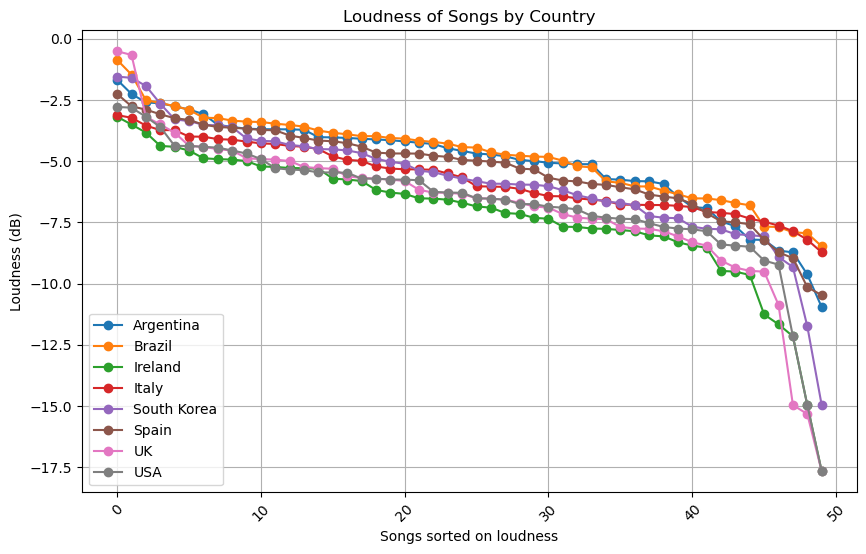

In [140]:
# Create a plot with sorted songs for each country
plt.figure(figsize=(10, 6))
for country, group in df_grouped:
    plt.plot(range(len(group['loudness'])), group['loudness'], marker='o', label=country, linestyle='-')

plt.title('Loudness of Songs by Country')
plt.xlabel('Songs sorted on loudness')
plt.ylabel('Loudness (dB)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

The scatter plot above shows that the loudest songs in all countries lie in the range -5 to 0 decibels and that the silent songs lie in the range -10 to -18 decibels. 

We can visualise the loudness across all the countries with a distribution curve.

<Axes: ylabel='Density'>

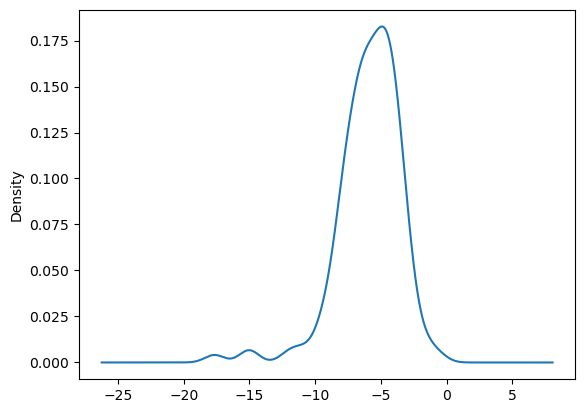

In [141]:
# Plot the normal distribution of all the loudness values
df_songs['loudness'].plot(kind='kde')


From the curve we can get a brief idea about the loudness popularity considering all the countries. It can be seen that most of songs will be under the percent of area covered between -10 and -3 dB where the Probability Density Function is maximum.

A preferrable way to visualise the loudness for each country is to create groups or bins for the loudness range. We can generate bins on the basis of a quartile range. In the quartile range the value at 25 percent of the distribution will give us the low threshold and the value at 75 percent of the distribution will give us the medium_threshold. 

In [142]:
quartiles = df_songs['loudness'].quantile([0.25, 0.75])

# Create thresholds to categorise song loudess
low_threshold = quartiles[0.25]
print(f"Low Threshold: {low_threshold}")
medium_threshold = quartiles[0.75]
print(f"Medium Threshold: {medium_threshold}")

# Create an empty DataFrame to store the counts
category_counts = pd.DataFrame(columns=['country', 'Low', 'Medium', 'High'])

# Get loudness values by country
loudness_by_country = df_songs_grouped['loudness']
# len(loudness_by_country)


Low Threshold: -7.1155
Medium Threshold: -4.32025


Now let us categorise songs based on each country.

In [143]:
# Loop through each country's loudness values and categorise them
for country, values in loudness_by_country:
    # print(values)
    low_counter = sum(1 for value in values if value < low_threshold)
    medium_counter = sum(1 for value in values if value >= low_threshold and value < medium_threshold)
    high_counter = sum(1 for value in values if value >= medium_threshold)
    
    category_counts = pd.concat([category_counts, pd.DataFrame({'country': [country], 'Low': [low_counter], 'Medium': [medium_counter], 'High': [high_counter]})], ignore_index=True)

In [144]:
# A function to add frequency labels on bar graphs
def add_count_labels(ax):
    offset = 5
    for p in ax.patches:
        ax.annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2., p.get_height() + offset), ha='center', va='center')

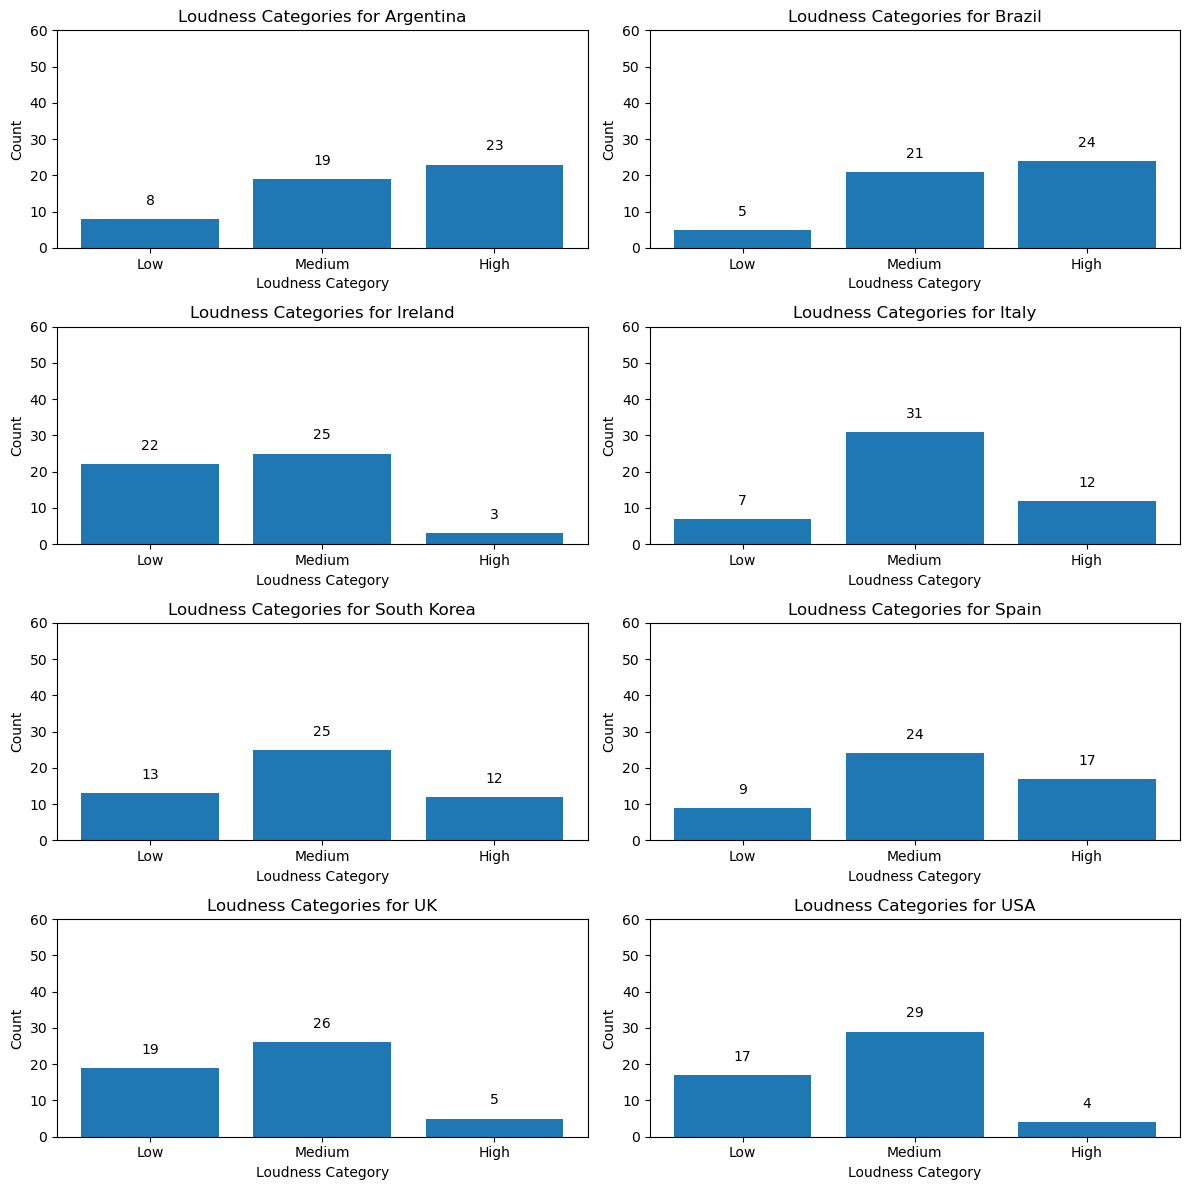

In [145]:
# Plotting the loudness graphs
graphs_per_row = 2
nrows = 4
fig, axes = plt.subplots(nrows=nrows, ncols=graphs_per_row, figsize=(12, 12))
#print(category_counts)
for i, row in category_counts.iterrows():
    country = row['country']
    categories = ['Low', 'Medium', 'High']
    counts = [row[category] for category in categories]
    # print(counts)
    row_index, col_index = divmod(i, 2)  # Calculate the row and column indices
    # print(row_index, " ", col_index )
    ax = axes[row_index, col_index]
    ax.bar(categories, counts)
    ax.set_title(f'Loudness Categories for {country}')
    ax.set_xlabel('Loudness Category')
    ax.set_ylabel('Count')
    ax.set_ylim(0, 60)  
    add_count_labels(ax)
plt.tight_layout()
plt.show()



Now it is crystal clear which country likes the loudest songs and it would be Brazil. 

Other countries like Argentina, Ireland, Italy, South Korea, Spain, UK and USA prefer songs with medium loudness. Argentina and Spain have likings for High Loudness songs too.

It is also seen that songs with Low loudness are more preferred in Ireland, UK, USA than High Loudness.


# Song Duration Analysis

The duration of a song also plays an important role, in popularity of a song. This analysis checks for 'what is the preference for a song length wise?'

We start again with getting the general statistics of song duration.

In [146]:
# Analysis of duration groups in each country
stats_df = compute_stats(df_songs,'country', 'duration_ms')
stats_df

,Max,Min,Mean,Median,Mode,Std Dev,Variance
country,,,,,,,
Argentina,383369,120600,182089.48,171809.0,120600,47334.032523,2.240511e+09
Brazil,641941,92093,180227.48,170330.0,92093,75047.103516,5.632068e+09
Ireland,547733,87000,212651.10,214405.5,87000,66598.862507,4.435408e+09
Italy,251321,113738,182980.82,181970.0,113738,31374.891567,9.843838e+08
South Korea,274387,130996,197701.62,203645.5,130996,32928.431235,1.084282e+09
Spain,338000,109048,194004.12,190486.5,109048,40488.435546,1.639313e+09
UK,547733,125902,207821.48,206848.0,125902,64201.507261,4.121834e+09
USA,319192,125040,202511.88,201736.0,125040,44760.948048,2.003542e+09


For a good understanding we can group the songs into bins and visualise them. We'll create bins of following categories:

- <b>Short Length Songs:</b> Songs with duration less than 150000 ms (150 seconds)
- <b>Medium Length Songs:</b> Songs with duration range 150000 ms (150 seconds) to 300000 ms (300 seconds)
- <b>Long Length Songs:</b> Songs with duration greater than 300000 ms (300 seconds)

These ranges are decided based on my understanding of how short or long a song is.

In [147]:
# Create bins for separating the durations
short_threshold = 150000
medium_threshold = 300000

# Create an empty DataFrame to store the counts
category_counts = pd.DataFrame(columns=['country', 'Short', 'Medium', 'Long'])

# Group loudness values by country
lengths_by_country = df_songs_grouped['duration_ms']

# lengths_by_country

Categorise songs in each country.

In [148]:
# Loop through each country's loudness values and categorise them
for country, values in lengths_by_country:
    # print(len(values))
    short_counter = sum(1 for value in values if value < short_threshold)
    medium_counter = sum(1 for value in values if value >= short_threshold and value < medium_threshold)
    long_counter = sum(1 for value in values if value >= medium_threshold)
    
    category_counts = pd.concat([category_counts, pd.DataFrame({'country': [country], 'Short': [short_counter], 'Medium': [medium_counter], 'Long': [long_counter]})], ignore_index=True)
    
#category_counts

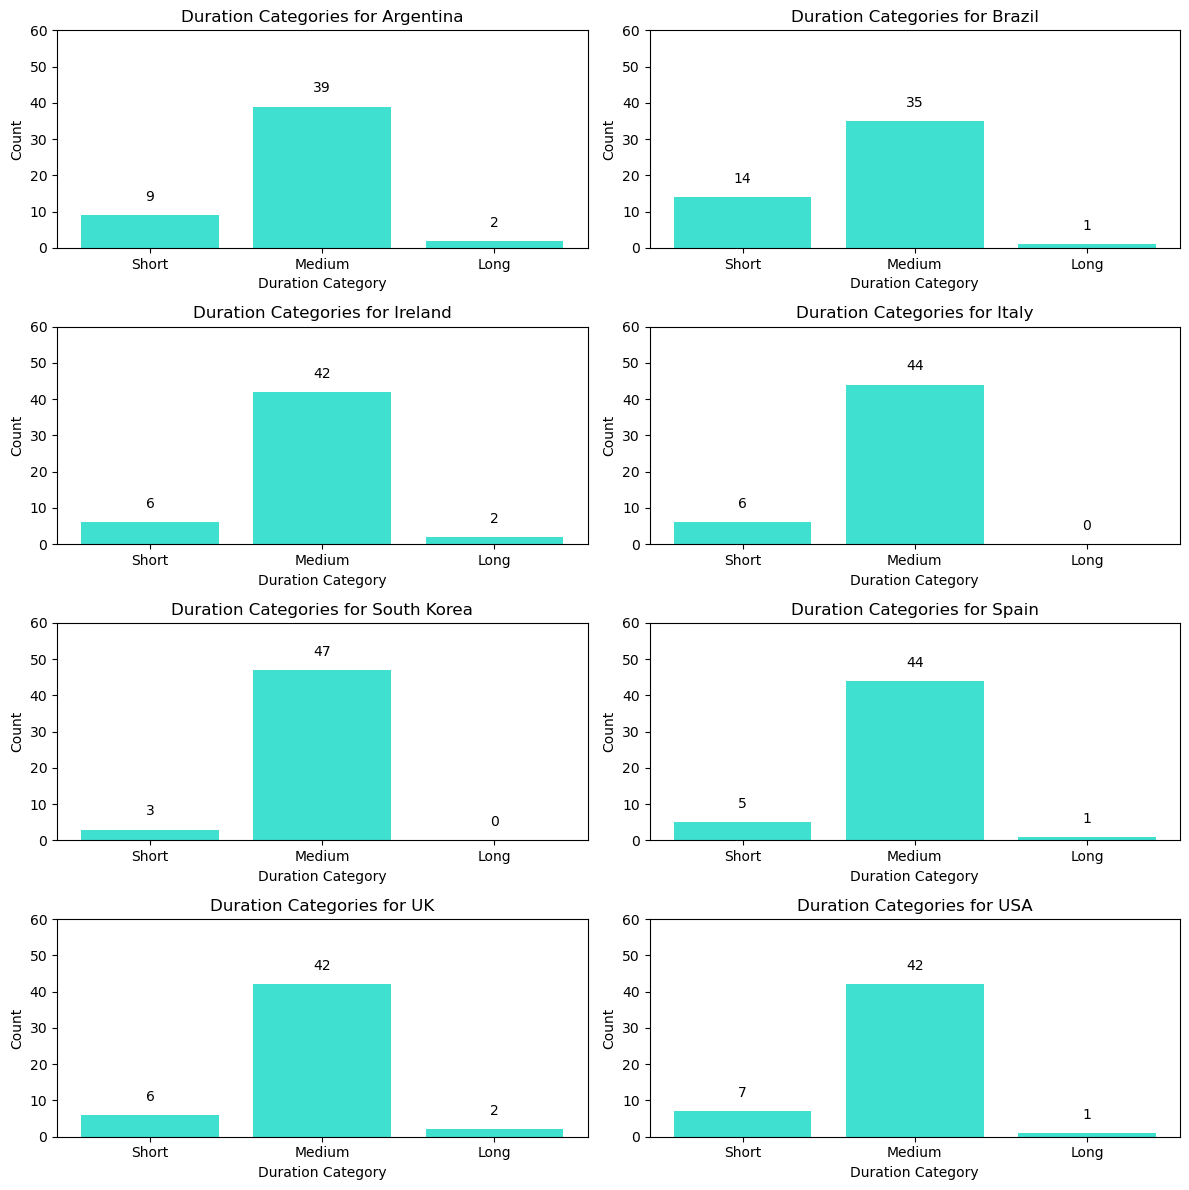

In [149]:
# Plot the counted categories
graphs_per_row = 2
nrows = 4
fig, axes = plt.subplots(nrows=nrows, ncols=graphs_per_row, figsize=(12, 12))
#category_counts = category_counts.drop('country')
#print(category_counts)
for i, row in category_counts.iterrows():
    country = row['country']
    categories = ['Short', 'Medium', 'Long']
    counts = [row[category] for category in categories]
    row_index, col_index = divmod(i, 2)  # Calculate the row and column indices
    # print(row_index, " ", col_index )
    ax = axes[row_index, col_index]
    ax.bar(categories, counts, color='turquoise')
    ax.set_title(f'Duration Categories for {country}')
    ax.set_xlabel('Duration Category')
    ax.set_ylabel('Count')
    ax.set_ylim(0, 60) 
    add_count_labels(ax)

plt.tight_layout()
plt.show()

Based on the frequency graphs around 80 percent of the top 50 songs in each country are in the range 150 to 300 seconds.

It is in very less cases that an artist will produce a song with duration less than 150 seconds.

And even more rare for an artist to produce a song with duration greater than 300 seconds.

We can also get the song durations to be visualised as <b>violin</b> plots. Similar to a box plot, a violin plot shows the range of values. And more better it also shows the density of the 
distribution.

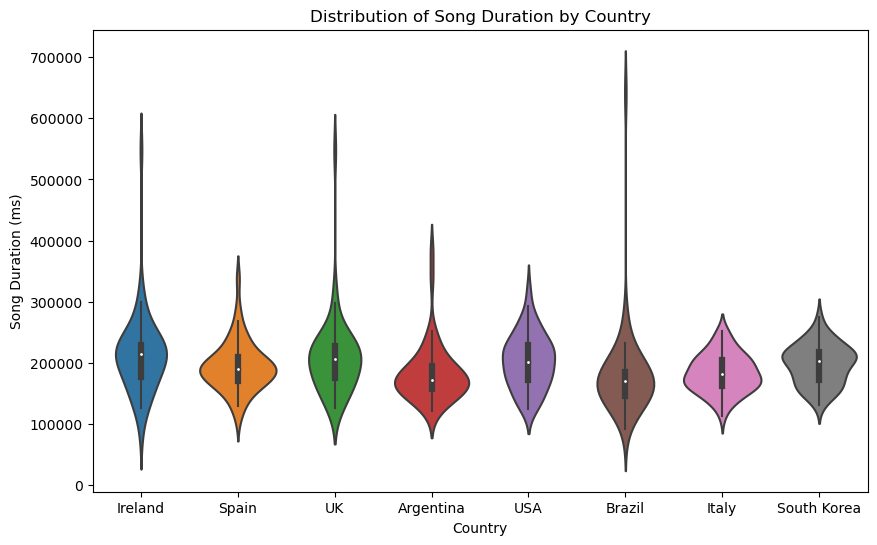

In [150]:
# Violin plot for data
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_songs, x='country', y='duration_ms', showfliers=True)
plt.title('Distribution of Song Duration by Country')
plt.xlabel('Country')
plt.ylabel('Song Duration (ms)')
plt.show()

We can easily comprehend that most of the songs for all countries lie in the range 150 to 300 seconds. Moreover we can see that there are outliers in countries like Brazil and UK where a few popular songs are greater than 400 seconds.

# Speechiness Analysis

Now, we are moving towards the "wordiness" in the songs.

Starting again with statistics summary for speechiness.

In [151]:
# Speechiness Statistics for songs wrt each country
stats_df = compute_stats(df_songs,'country', 'speechiness')
stats_df

,Max,Min,Mean,Median,Mode,Std Dev,Variance
country,,,,,,,
Argentina,0.307,0.0285,0.078848,0.06405,0.0381,0.053282,0.002839
Brazil,0.592,0.0275,0.118440,0.08075,0.0275,0.119358,0.014246
Ireland,0.241,0.0287,0.067402,0.04930,0.0400,0.050265,0.002527
Italy,0.455,0.0285,0.135746,0.09975,0.1660,0.109801,0.012056
South Korea,0.157,0.0266,0.058716,0.04455,0.0324,0.033286,0.001108
Spain,0.601,0.0285,0.116856,0.07175,0.0381,0.108755,0.011828
UK,0.478,0.0256,0.086740,0.05445,0.0319,0.086519,0.007485
USA,0.478,0.0299,0.107390,0.06410,0.0299,0.099644,0.009929


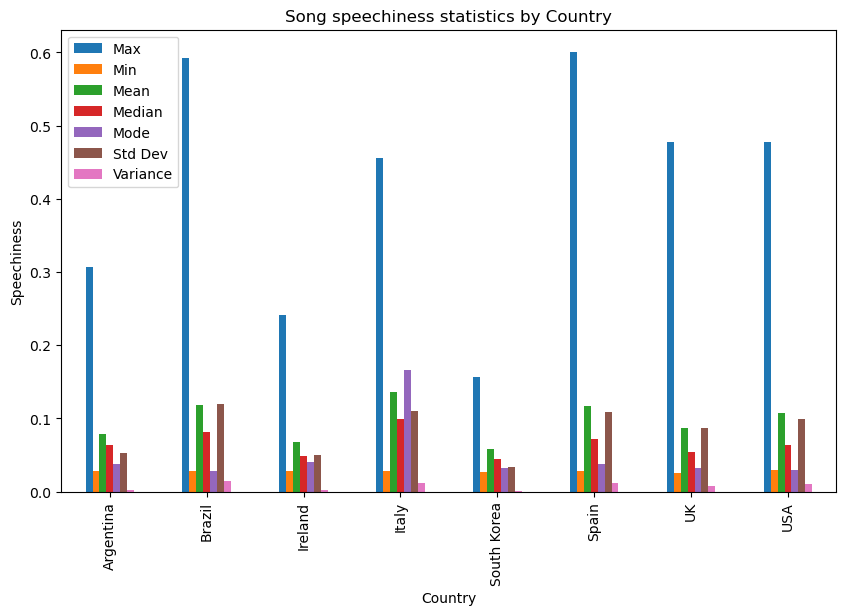

In [152]:
# Plot the graph of the speechiness statistics
stats_df.plot(kind='bar', figsize=(10, 6))
plt.title('Song speechiness statistics by Country')
plt.ylabel('Speechiness')
plt.xlabel('Country')
plt.show()

We can observe that the maximum speechiness for each country lies in the range 0.15 to 0.6 while the minimum speechiness for each country is even less than 0.5.

For a deeper understanding let's create a box plot.

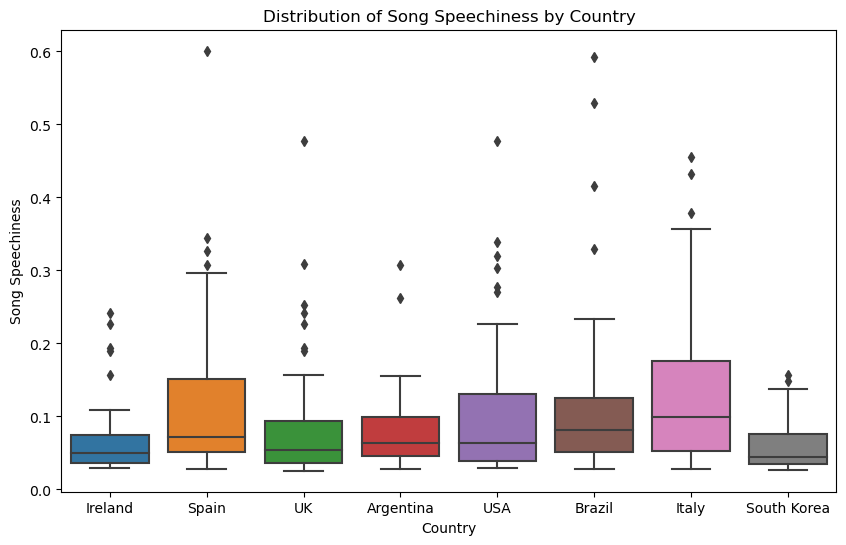

In [153]:
# Create a box plot for all songs based on speechiness
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_songs, x='country', y='speechiness', showfliers=True)
plt.title('Distribution of Song Speechiness by Country')
plt.xlabel('Country')
plt.ylabel('Song Speechiness')
plt.show()

The common range for speechiness of popular songs in the countries is from 0.0 to 0.2. The median lies in the range 0.0 to 0.1.

We can verify this data since popular songs these days have a very few spoken words. In countries like Spain or Brazil there are outliers present which are way beyond the normal range for speechiness. This indicates that in these countries, raps are quite popular form of music too as they contain more words than the genres Hip Hop or Country Music.

Let's see how the factors- energy, danceability and speechiness relate to each other by taking an average for each country.

In [154]:
# Get the average of energy, danceability and speechiness
columns_to_mean = ['energy', 'danceability', 'speechiness']
grouped_data = df_grouped[columns_to_mean].mean()
grouped_data = grouped_data.reset_index()
grouped_data

,country,energy,danceability,speechiness
0,Argentina,0.691880,0.72846,0.078848
1,Brazil,0.739300,0.66926,0.118440
2,Ireland,0.612722,0.61942,0.067402
3,Italy,0.710940,0.70892,0.135746
4,South Korea,0.646280,0.62766,0.058716
5,Spain,0.699520,0.73854,0.116856
6,UK,0.626762,0.63196,0.086740
7,USA,0.641162,0.67012,0.107390


A neat representation would be to display these factors as radar graphs. The function below creates a radar graph given the country and the column name.

In [155]:
# Radar chart of each country wrt (energy, danceability, speechiness)
def create_radar_charts(df, countries, columns):
    cols = 2
    rows = len(countries) // cols
    # Create subplots with 'polar' subplot type with rows, cols
    fig = make_subplots(rows=rows, cols=cols, subplot_titles=[f'{country}' for country in countries], specs=[[{'type': 'polar', 'colspan': 1}]*cols]*rows)
    # Loop through all the country data
    for i, country in enumerate(countries):
        country_data = df[df['country'] == country]
        radar_chart = go.Figure()

        for column in columns:
            radar_chart.add_trace(go.Scatterpolar(
                r=country_data[column],
                theta=columns,
                fill='toself',
                name=column,
                showlegend=False
            ))
        row_index, col_index = divmod(i, 2) 
        # Add the radar chart to the subplot
        fig.add_trace(radar_chart.data[0], row=row_index+1, col=col_index+1)

    
    # Define polar coordinates on radius
    fig.update_polars(radialaxis=dict(range=[0, 1]))
    # Update layout to set the chart size
    fig.update_layout(
        height=400 * rows,  
        width=800, 

    )
    #print(fig)

    # Show the combined radar charts
    fig.show()



# Define and columns for the radar charts
columns_to_plot = ['energy', 'danceability', 'speechiness']

# Create radar charts
create_radar_charts(df_songs, locations_of_interest, columns_to_plot)


From the radar plots we can check that in the countries like UK and Brazil, higher danceability factor is linked to higher energy. Speechiness has little influence over the attributes as no direct proportionality can be seen and it lies in the range 0.4-0.8 commonly for all countries.

# Song Artist Analysis

Let us segue to the people who actually have an influence over all the attributes we have seen so far and ultimately over the song itself.

We can start with checking out which artist is popular in each country. This can done by counting the name for each artist as they have appeared in all the top 50 songs.

In [156]:
# Find the trending artists in each country
# Explode the Artist array to separate artists into separate rows
df_artists = df_songs.explode('artists', ignore_index=True)
                              
# Group by Country and Artist, then count the occurrences
artist_counts = df_artists.groupby(['country', 'artists']).size().reset_index(name='count')

# Sort the artists within each country based on the highest count
artist_counts = artist_counts.sort_values(['country', 'count'], ascending=[True, False])
                              
# country_tables = {}
# for country, group in artist_counts.groupby('country'):
#     # Generate an HTML table for each country's data
#     country_table = group[['artists', 'count']].to_html(index=False)
#     country_tables[country] = country_table

# for country, table in country_tables.items():
#     print(f"\nCountry Name: {country}")
#     # Display the HTML table
#     display(HTML(table))



We can put the numbers of all the featured artists on a bar chart and have a visual output.

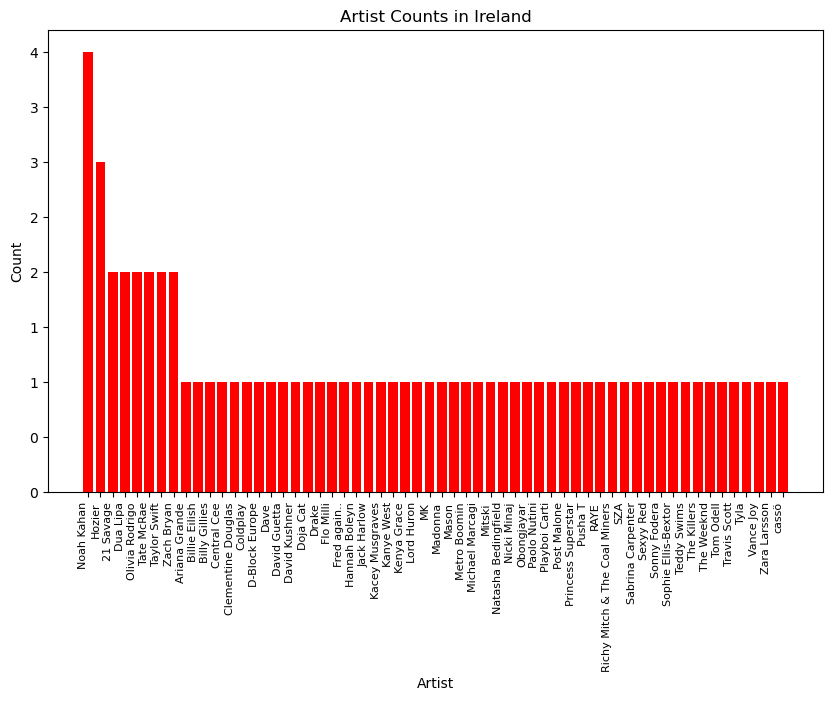

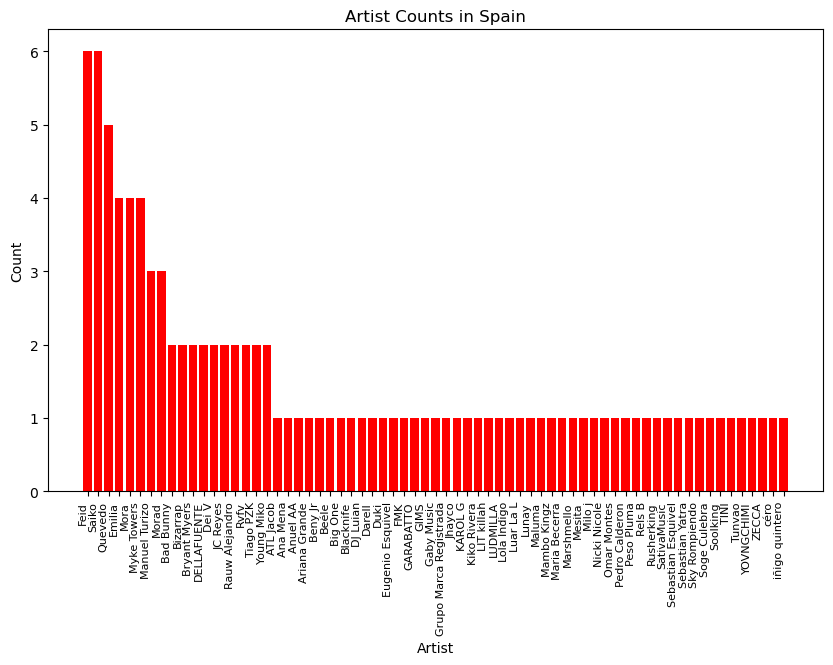

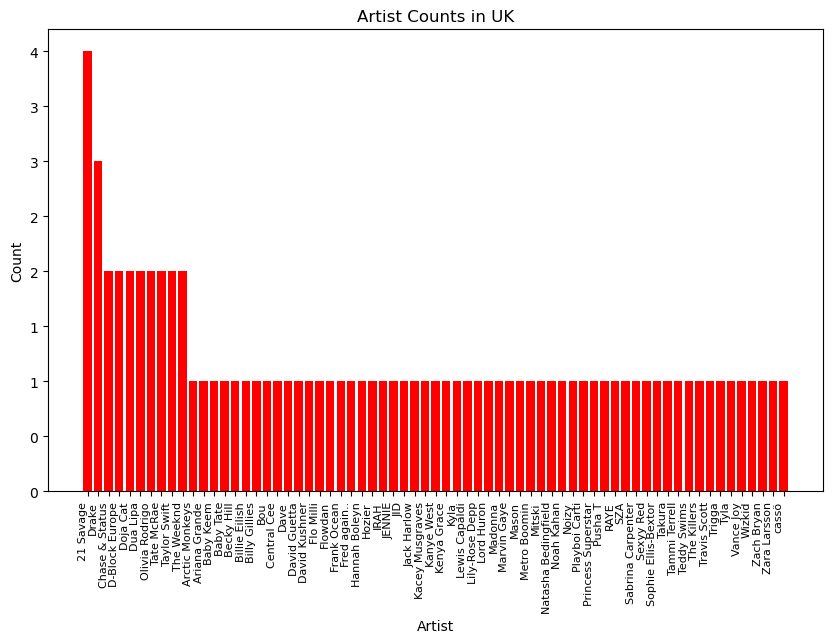

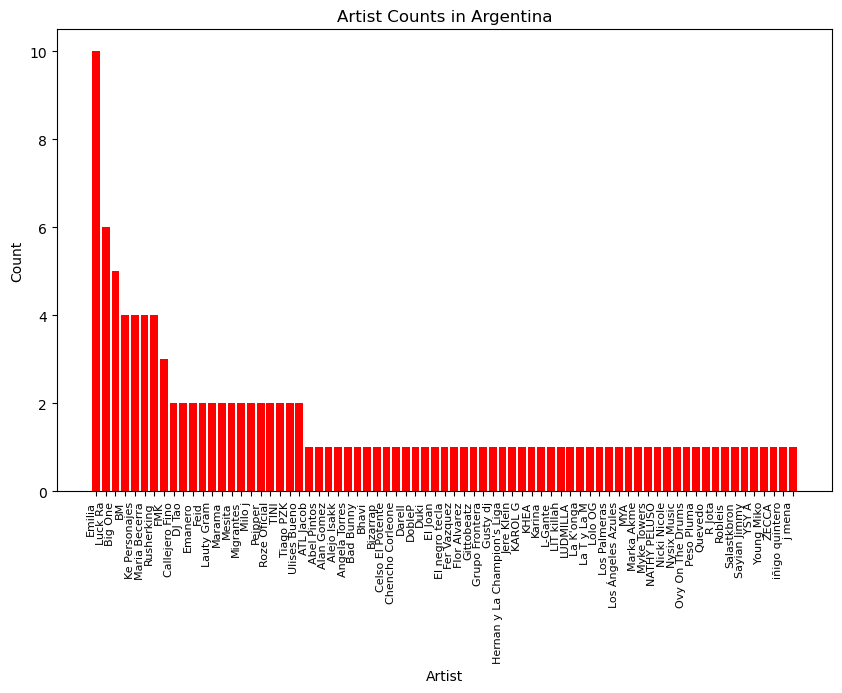

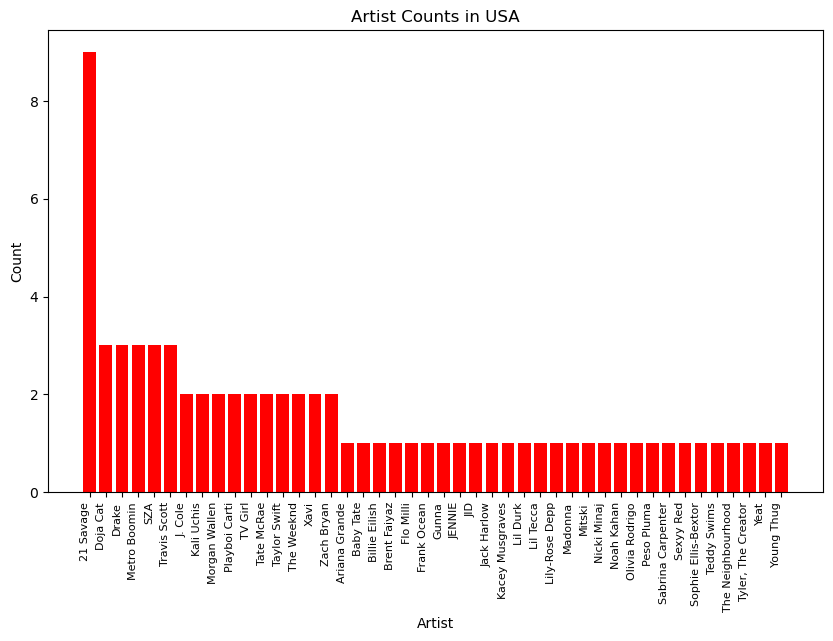

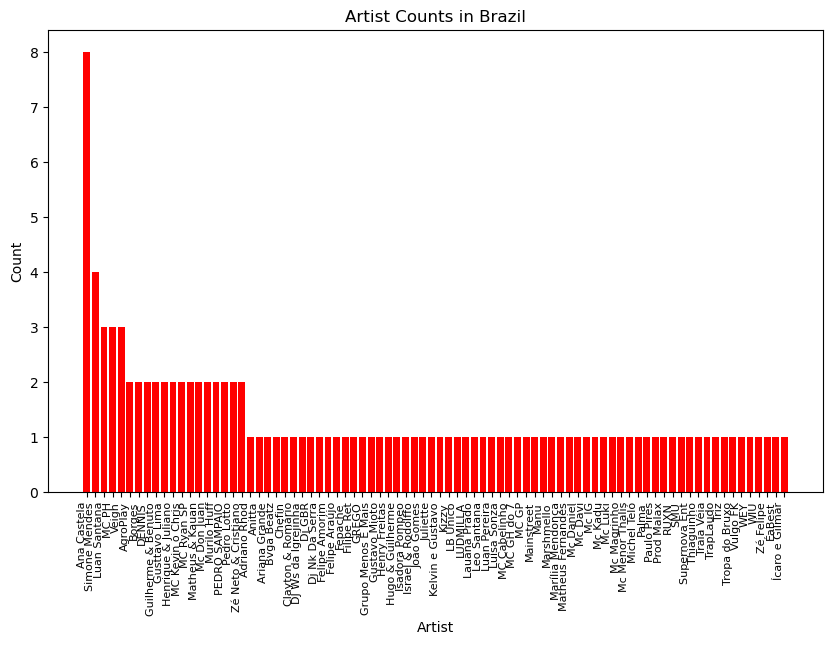

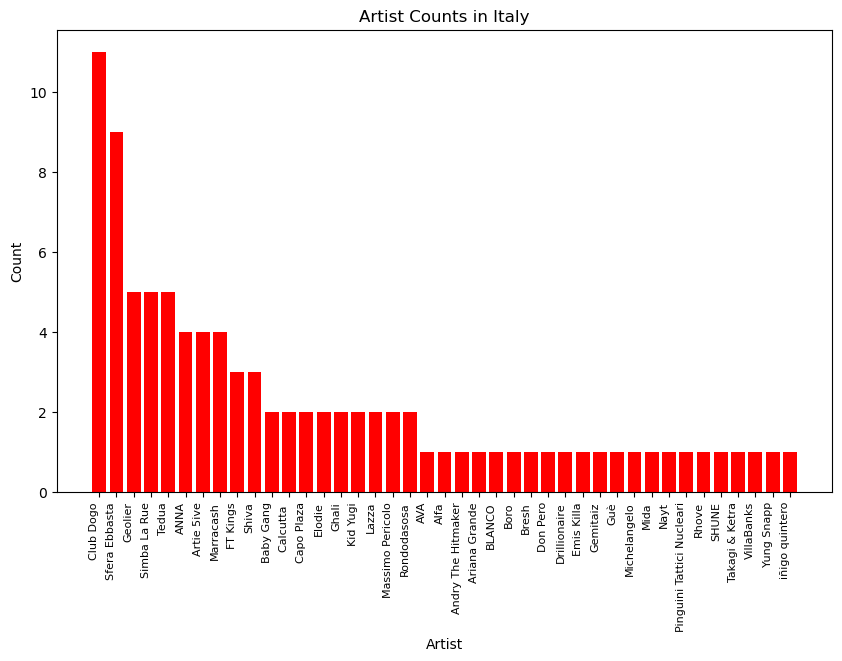

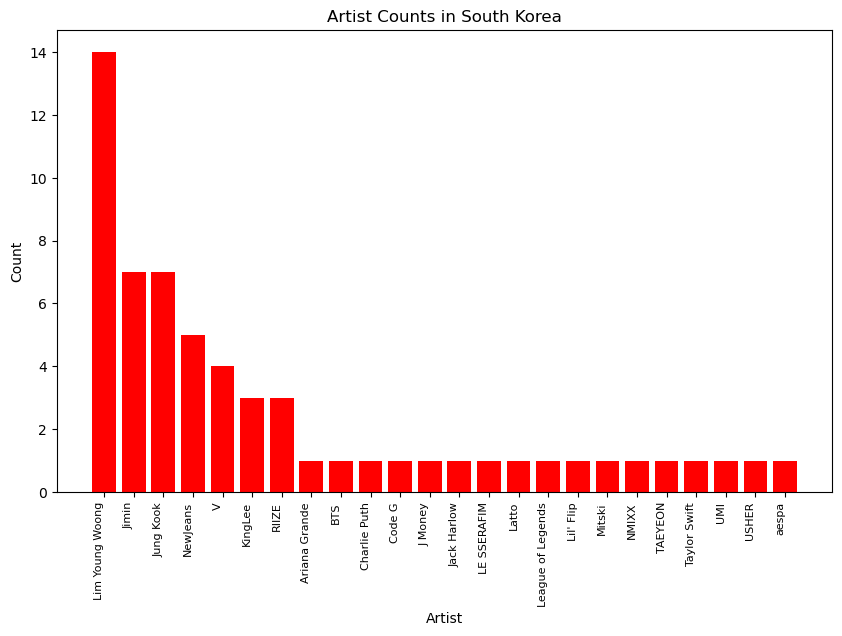

In [157]:

for country in locations_of_interest:
    country_data = artist_counts[artist_counts['country'] == country]
    plt.figure(figsize=(10, 6))
    plt.bar(country_data['artists'], country_data['count'], color="red")
    plt.title(f'Artist Counts in {country}')
    plt.xlabel('Artist')
    plt.ylabel('Count')
    plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    plt.xticks(rotation=90, ha='right', fontsize=8)
    plt.show()

The top artists featured in the popular songs for each country are as follows:
- <b>Ireland</b>: Taylor Swift, Olivia Rodrigo, Zach Bryan
- <b>Spain</b>: Saiko, Bad Bunny, Quevedo
- <b>UK</b>: Taylor Swift, Chase & Status, SZA
- <b>Argentina</b>: Milo J, BM, Big One
- <b>USA</b>: Taylor Swift, Drake, SZA
- <b>Brazil</b>: Ana Castela, Simone Mendes, Felip Amorim
- <b>Italy</b>: Artie 5ive, Geolier, Sfera Ebbasta
- <b>South Korea</b>: Lim Young Woong, Jimin, V

We can conclude that Taylor Swift is a highly popular singer among the top featured.

# Numeric Attribute Correlation Analysis

Let us try to find out if there is any correlation between the numeric variables.

A parallel coordinate plot can help us with identifying common trends across all attributes in a single graph.

In [158]:
# Plot a parallel coordinate graph between all the numeric variables
fig = go.Figure(data=
    go.Parcoords(
        line = dict(
        colorscale = [[0,'purple'],[0.5,'lightseagreen'],[1,'gold']]),
        dimensions = list([
            dict(label = 'Energy', values = df_songs['energy']),
            dict(label = 'Danceability', values = df_songs['danceability']),
            dict(label = 'Loudness', values = df_songs['loudness']),
            dict(label = 'Speechiness', values = df_songs['speechiness']),
        ])
    )
)
# Set figure parameters
fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white'
)
# Show figure
fig.show()

We see that the most common trend in all the songs from the listed countries taken into consideration is, on an average, the top songs have a energy range between 0.4 and 0.9 along with danceability range of 0.45 to 0.9, a loudness in range -3 to -10 and a speechiness between 0 to 0.15.

If we plot a heatmap of all these numeric values we can get to know which of the variables are related.

We will create a correlation matrix by dropping all the non numeric columns.

<Axes: >

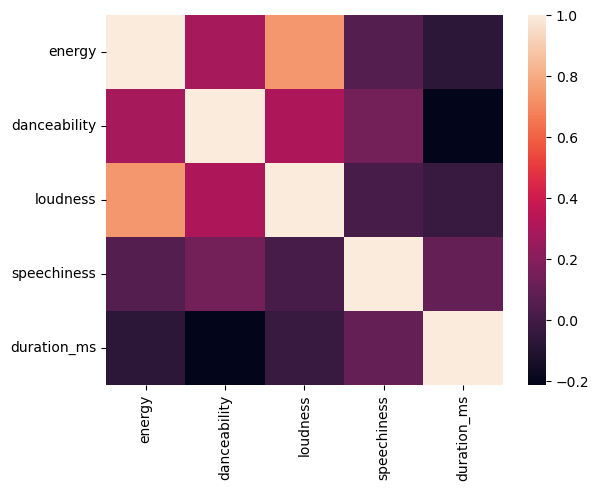

In [159]:
# Get the dataframe
corr_df = df_songs
# Drop non numeric columns
corr_df = corr_df.drop(['country','artists'], axis=1)
# Find the correlation matrix
corr_df = corr_df.corr()
# Plot the heatmap of correlation matrix
sns.heatmap(corr_df) 

We observe that the only strong relation between the variables is in between energy and loudness accounting for nearly 70 percent. We can conclude that other variables don't have any sort of direct relations with each other.

# Conclusions:

In this assignment we have analysed the trends in the top 50 songs for 8 different countries. My aim was to assess what factors caused a song to gain high popularity in different countries. I focused on the audio features of energy, danceability, loudness, speechiness, audio duration and the artists. Based on the overall analysis I found different countries have a few common traits in their top songs. Regardless of the region or the artist, the most common trait observed  for the popular songs to have a mid to high energy range along with medium danceability, a mid ranged loudness and a low speechiness.

When working on the assignment my first challenge was to gather enough data for analysis. Most of the APIs like Spotify have a limit on the number of GET requests a user can make to fetch data. So I learned to check the response messages and got to know about the limits. As a solution I applied a timeout to the loop when fetching data so too many requests weren't made at the same time.

The next challenge I faced was to select the right attributes for trend analysis on the song data. Spotify offers a large amount of data which can be confusing at times. If right attributes weren't chosen, one might end up with wrong deductions. I settled on the most significant numeric variables so that I could visualise them with various graphs.

To extend onto my assignment I have a few pointers which could be considered for further analysis:
- A song's lyrics could be analysed for common words spoken in a country using MusixMatch API (https://developer.musixmatch.com/).
- More attributes like accousticness, liveness, mode, tempo, time_signature could be used for exhaustive analysis.
- Network Graphs can be created for all the artists to look for any common network connections between them.
